# Project Overview

This notebook was created to calculate fantasy baseball auction draft values. The idea was to automate (to the extent possible) the work that I used to do in Excel. 

The formulas and methods come from the book [*Winning Fantasy Baseball*](https://www.amazon.com/gp/product/1937110575/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=robertborg-20&creative=9325&linkCode=as2&creativeASIN=1937110575&linkId=b219e46c1a68b1669cb306c96ca6abd9), which became an essential resource for me once I started playing in an auction league.

Full disclosure: I haven't won my league in a while, not since 2007 to be exact. I just don't have the time to keep up with the day-to-day transactions and strategy anymore, but I do draft pretty well.

There are other tools out there that automate this sort of thing, but I think there's value in understanding the math and process behind how you get to your valuations, so you know when to override the system and when to trust it. And if you play in a league that's non-standard in any way, the \\$ values you get online may not fit your league.

Also, if your leaugue uses different scoring categories, you'll have to customize things a bit, especially for the ratio stats. 

And if you're experienced with Python, Pandas, or coding in general, you might find some things that could be done better or more elegantly. Feel free to contact me with corrections for formulas or just better ways to do things.


In [1]:
# imports!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


## Set up your league

Start by inputting the various league settings:

In [2]:
# League Settings
hitter_categories = ['R','HR','RBI','SB','OBP']
pitcher_categories = ['QS','SO','SV','ERA','WHIP']
league_categories = hitter_categories + pitcher_categories
    
teams_in_league = 14
roster_size_total = 29
draft_budget = 300
carryover_money = 41 # money leftover from previous year's draft, not applicable to all leagues

league_positions = {
    'hitters': 13, # the number of starting hitters (don't include bench players)
    'pitchers': 12 # the number of pitchers you generally draft
}

# The Draft Pool
hitters_drafted = 15 
pitchers_drafted = roster_size_total - hitters_drafted 

hitters_in_pool = hitters_drafted * teams_in_league
pitchers_in_pool = pitchers_drafted * teams_in_league

draft_pool_total = hitters_in_pool + pitchers_in_pool


## What does it take to win in your league?

The idea behind the draft values for each player come from something called Standings Gained Points (SGPs). The idea is that for each scoring category, a certain quantity of that stat will move you up one place in the standings. What we're looking for is the slope of a given category.

If we take runs as an example, you might need 23 runs at the margin to move up one place in the standings. By calculating SGPs, we can estimate the value of a given players runs and how they will directly contribute to your team.

Some caveats:

1. If this is the first year of your league, you won't be able to calculate last year's stats. My advice is to go and find another league that you've played in and use the historical stats from that league. Or you can make an educated guess.
2. Historical data has been a little more volatile in the last few years with the massive surge in homeruns. So you may want to manually adjust your league history if you think the next season's scoring environment will be different.


In [3]:
# Create a DataFrame based on last year's CSV
last_year_stats = pd.read_csv('League_Data/last_year_stats.csv',thousands=',')

# Initialize the dictionary that will store the slopes for each category
my_league_history = {}

# The x axis is the number of teams in the league. 
x_axis_league_history = np.reshape(range(0,teams_in_league),(-1,1))

for category in league_categories:
    # get last year's data for the category, sort it, and shape it
    y_axis = last_year_stats[category].sort_values().values.reshape(-1,1) # sort_values(by=row)

    # create a new LinearRegression() object
    linear_regression_category = LinearRegression()
    
    # run the regression
    linear_regression_category.fit(x_axis_league_history,y_axis)
    
    # assign the regression coefficient to my_league_history dictionary
    my_league_history[category] = float(linear_regression_category.coef_)

# Create averages for hitter ratio stats (OBP)
historical_mean_obp = last_year_stats['OBP'].mean()

# Calculate the number of PAs for x-1 slots, where x = hitter_roster_size (used later in SGP calculations for OBP)
first_x_hitter_plate_appearances = 600 * (league_positions['hitters'] - 1)

# (used for calculating OBP SGPs later) 
team_historical_on_bases = first_x_hitter_plate_appearances * historical_mean_obp

# Create averages for pitcher ratio stats (WHIP, ERA). This varies by league. Easier if you have an IP limit but I don't
estimated_mean_ip_per_team = 1400 

# WHIP
historical_mean_whip = last_year_stats['WHIP'].mean()
team_historical_walks_plus_hits = estimated_mean_ip_per_team * historical_mean_whip

# ERA
historical_mean_era = last_year_stats['ERA'].mean()
team_historical_earned_runs = (estimated_mean_ip_per_team / 9) * historical_mean_era

print(my_league_history)
print('\n')
print(historical_mean_whip)
print(team_historical_walks_plus_hits)
print('\n')
print(historical_mean_era)
print(team_historical_earned_runs)


{'R': 23.017582417582414, 'HR': 11.195604395604395, 'RBI': 26.758241758241752, 'SB': 7.026373626373626, 'OBP': 0.002072527472527469, 'QS': 5.032967032967033, 'SO': 44.83956043956044, 'SV': 8.980219780219779, 'ERA': 0.06898901098901097, 'WHIP': 0.01375824175824175}


1.2704285714285715
1778.6000000000001


3.9635714285714294
616.5555555555557


### Organize our player data

Next we're going to import our hitter and pitcher projections and start to manipulate the data. I'm using [Steamer projections from Fangraphs](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=steamer). This will work for any set of projections, although you may have to change the column labels to match the code below.



In [4]:
# Create a dataframe for the hitter data and the pitcher data (we will combine them later)
hitters = pd.read_csv('Projections/Steamer_Hitters.csv')
pitchers = pd.read_csv('Projections/Steamer_Pitchers.csv')

# You should see two dataframes, one for hitters and one for pitchers information.
print(hitters.head())

print(pitchers.head())


               Name     Team    G   PA   AB    H  2B  3B  HR    R  ...  wRC+  \
0        Mike Trout   Angels  150  675  528  157  29   3  44  124  ...   173   
1      Alex Bregman   Astros  150  658  549  158  38   2  33  106  ...   150   
2  Francisco Lindor  Indians  150  692  616  178  39   2  36  112  ...   125   
3    Cody Bellinger  Dodgers  150  640  544  156  30   3  42  100  ...   147   
4      Mookie Betts  Dodgers  150  688  589  165  38   3  32  112  ...   132   

   BsR   Fld  -1.2   Off   Def  WAR  -1.3   ADP  playerid  
0  3.1  -1.7   NaN  66.3   0.6  8.8   NaN   2.3     10155  
1  0.1  -1.8   NaN  42.2   0.9  6.4   NaN  15.8     17678  
2  0.7   7.8   NaN  22.7  15.3  6.1   NaN   8.2     12916  
3  1.2   0.8   NaN  41.0   0.7  6.1   NaN   4.4     15998  
4  4.5  12.7   NaN  33.3   5.3  5.9   NaN   6.0     13611  

[5 rows x 33 columns]
                Name       Team   W   L   ERA  GS   G  SV     IP    H  ...  \
0       Jacob deGrom       Mets  14   9  3.12  32  32   0 

In [5]:
# Create a list of labels that we want to preserve
column_labels = ['Name','PA','IP']

# Gah! Lots of columns we don't need. Let's drop them!
for column in hitters:
    # If the column name doesn't match an item in the hitter_categories or our labels, drop it.
    # You can add logic here to preserve some columns for stuff like Team or whatever else you want to keep.
    if column not in hitter_categories and column not in column_labels:
        hitters.drop(labels=column,axis=1,inplace=True)
        
# Create a lambda function to calculate QS. Filter for pitchers with more than 90 IP to limit it to starters.
# Since Steamer doesn't include QS projections, I multiply wins by 1.5, which has generally worked in the past.
calculate_qs = lambda row: ( row['W'] * 1.5 if row['IP'] > 90 else 0 )

# Create a new column for QS with our lambda function
pitchers['QS'] = pitchers.apply(calculate_qs,axis=1)

# If the column name doesn't match an item in the pitcher_categories or our new labels, drop it
for column in pitchers:
    if column not in pitcher_categories and column not in column_labels:
        pitchers.drop(labels=column,axis=1,inplace=True)

# Now our dataframes should look nice and clean, with our league data plus some essential info. You can of course
# choose to leave more info in, like team, league, WAR, whatever you want to have in front of you while drafting.
print(hitters.head())
print(pitchers.head())


               Name   PA  HR    R  RBI  SB    OBP
0        Mike Trout  675  44  124  112  14  0.439
1      Alex Bregman  658  33  106  103   6  0.396
2  Francisco Lindor  692  36  112   95  22  0.355
3    Cody Bellinger  640  42  100  116  12  0.386
4      Mookie Betts  688  32  112   87  17  0.371
                Name   ERA  SV     IP   SO  WHIP    QS
0       Jacob deGrom  3.12   0  205.0  259  1.06  21.0
1        Gerrit Cole  3.26   0  202.0  281  1.04  22.5
2       Max Scherzer  3.27   0  202.0  268  1.04  22.5
3  Stephen Strasburg  3.58   0  200.0  229  1.17  21.0
4   Justin Verlander  3.45   0  184.0  240  1.04  21.0


## Calculating SGPs

Now we can calculate our SGPs. For counting stats, it's pretty straightfoward -- you just divide a player's projected total for a given category by the slope that we calculated earlier.

For ratio stats, it's a bit trickier. We are trying to calculate the marginal impact that a player would have on a team's OBP, ERA, or WHIP, if we added him to our starting lineup.


In [6]:
# We start with the hitters...
for category in hitter_categories:
    # Calculate the SGPs for the counting stats
    if category != 'OBP':
        hitters[category + '_sgp'] = hitters[category] / my_league_history[category]

    # Calculating SGPs for OBP is kind of a pain!
    elif category == 'OBP':    
        hitters[category + '_sgp'] = (\
            ((( team_historical_on_bases + (hitters['PA'] * hitters['OBP']) ) / \
              ( first_x_hitter_plate_appearances + hitters['PA'] ) ) - historical_mean_obp) / my_league_history['OBP'])

        
# Let's total up all of the SGPs in a single cell, with this completely clunky code
sum_the_hitter_sgps = lambda row: ( row['R_sgp'] + row['HR_sgp'] + row['RBI_sgp'] + row['SB_sgp'] + row['OBP_sgp'])
hitters['Total_SGPs'] = hitters.apply(sum_the_hitter_sgps,axis=1)

# You should have a bunch of new columns now, ending in '_sgp', plus a column at the end with the SGP total
print(hitters.head())


               Name   PA  HR    R  RBI  SB    OBP     R_sgp    HR_sgp  \
0        Mike Trout  675  44  124  112  14  0.439  5.387186  3.930114   
1      Alex Bregman  658  33  106  103   6  0.396  4.605175  2.947585   
2  Francisco Lindor  692  36  112   95  22  0.355  4.865846  3.215548   
3    Cody Bellinger  640  42  100  116  12  0.386  4.344505  3.751472   
4      Mookie Betts  688  32  112   87  17  0.371  4.865846  2.858265   

    RBI_sgp    SB_sgp   OBP_sgp  Total_SGPs  
0  4.185626  1.992493  4.209589   19.705009  
1  3.849281  0.853926  2.375119   14.631086  
2  3.550308  3.131060  0.752471   15.515233  
3  4.335113  1.707851  1.921570   16.060512  
4  3.251335  2.419456  1.421852   14.816752  


Now let's do the pitchers...

In [7]:
for category in pitcher_categories:
    # Run the counting stats
    if category != 'WHIP' and category != 'ERA':
        pitchers[category + '_sgp'] = pitchers[category] / my_league_history[category]

    # Calculate WHIP
    elif category == 'WHIP':
        pitchers[category + '_sgp'] = \
        ((historical_mean_whip - ((team_historical_walks_plus_hits + (pitchers['IP'] * pitchers['WHIP'])) \
                                  /( pitchers['IP'] + estimated_mean_ip_per_team)))/ my_league_history['WHIP'])

    # Calculate ERA
    elif category == 'ERA':
        pitchers[category + '_sgp'] = \
        ( (historical_mean_era - (( pitchers['IP'] / 9 * pitchers['ERA'] + team_historical_earned_runs) * \
                                  (9 / ( pitchers['IP'] + estimated_mean_ip_per_team)))) / my_league_history['ERA'])

# Inelegantly sum them up...
sum_the_pitcher_sgps = lambda row: ( row['QS_sgp'] + row['SO_sgp'] + row['SV_sgp'] + row['ERA_sgp'] + row['WHIP_sgp'])
pitchers['Total_SGPs'] = pitchers.apply(sum_the_pitcher_sgps,axis=1)

# And take a look at what we have. It's likely that the SGPs for pitchers will be lower than for the hitters.
print(pitchers.head())


                Name   ERA  SV     IP   SO  WHIP    QS    QS_sgp    SO_sgp  \
0       Jacob deGrom  3.12   0  205.0  259  1.06  21.0  4.172489  5.776149   
1        Gerrit Cole  3.26   0  202.0  281  1.04  22.5  4.470524  6.266788   
2       Max Scherzer  3.27   0  202.0  268  1.04  22.5  4.470524  5.976865   
3  Stephen Strasburg  3.58   0  200.0  229  1.17  21.0  4.172489  5.107097   
4   Justin Verlander  3.45   0  184.0  240  1.04  21.0  4.172489  5.352416   

   SV_sgp   ERA_sgp  WHIP_sgp  Total_SGPs  
0     0.0  1.561783  1.953532   13.463954  
1     0.0  1.285929  2.111846   14.135087  
2     0.0  1.267652  2.111846   13.826887  
3     0.0  0.694986  0.912440   10.887013  
4     0.0  0.864736  1.945522   12.335163  


## Preparing the draft pool and a bit of cleanup

Before we can calcualte \\$ values, we need to remove players that won't be in the draft pool.

We'll start by figuring out exactly how many pitchers and hitters should be in our draft pool and removing the rest. To do this, we're going to revisit two variables that we defined up top, `hitters_in_pool` and `pitchers_in_pool`.

These numbers may be somewhat arbitrary because many leagues have a certain number of bench spots that can be taken by either a hitter or pitcher. So how many hitters should you accounting for in your pool? 

Generally I estimate the number of hitters per team by looking at how many starting spots there are for each hitter and then adding the number of bench spots that the average team will use for hitters. So you might have 13 starting hitters and then 3 out of the 5 bench spots also allocated for hitters.

If you're not sure, you can guess, or if you can look at the previous year's draft to see how people drafted.

Getting this 100\% correct isn't the goal. And it's impossible, unless your league has very strict roster rules.




In [8]:
# Sort by SGPs so we can keep just the best players in the pool
pitchers.sort_values(by=['Total_SGPs'],ascending=False,inplace=True,ignore_index=True)
hitters.sort_values(by=['Total_SGPs'],ascending=False,inplace=True,ignore_index=True)

# Select only the players we want in the pool
draft_pool_hitters = hitters.iloc[:hitters_in_pool]
draft_pool_pitchers = pitchers.iloc[:pitchers_in_pool]

# Now we can join the hitters and pitchers to create our draft pool
draft_pool = pd.concat([draft_pool_hitters,draft_pool_pitchers],axis=0, ignore_index=True, sort=True)

# Print your draft pool and make sure you have the right number of players (teams in your league x roster size)
print(draft_pool)

      ERA   ERA_sgp    HR    HR_sgp     IP              Name    OBP   OBP_sgp  \
0     NaN       NaN  44.0  3.930114    NaN        Mike Trout  0.439  4.209589   
1     NaN       NaN  36.0  3.215548    NaN  Christian Yelich  0.400  2.586097   
2     NaN       NaN  37.0  3.304868    NaN  Ronald Acuna Jr.  0.363  1.073647   
3     NaN       NaN  42.0  3.751472    NaN    Cody Bellinger  0.386  1.921570   
4     NaN       NaN  36.0  3.215548    NaN  Francisco Lindor  0.355  0.752471   
..    ...       ...   ...       ...    ...               ...    ...       ...   
401  3.54  0.260370   NaN       NaN   62.0       Will Harris    NaN       NaN   
402  4.88 -1.016430   NaN       NaN  116.0      Gio Gonzalez    NaN       NaN   
403  4.77 -0.979203   NaN       NaN  128.0  Kendall Graveman    NaN       NaN   
404  3.45  0.296136   NaN       NaN   58.0      Luke Jackson    NaN       NaN   
405  3.31  0.339273   NaN       NaN   52.0      Chris Martin    NaN       NaN   

        PA    QS  ...     R

## A bit of cleanup

The hard work is ahead, but the good news is that if you play in a snake draft, you would do pretty well with just what we have so far. 

Before we calculate \\$ values, let's clean up our data a bit.


In [9]:
# Replace the NaNs with something more aesthetically pleaseing
draft_pool.fillna(value="x",inplace=True)

# Get rid of these _sgp columns
for column in draft_pool:
    if "_sgp" in column:
        draft_pool.drop(labels=column,axis=1,inplace=True)
        
# And let's add a column to tell us whether or not the player is a hitter or pitcher.
draft_pool['Class'] = draft_pool.IP.apply(lambda x: 'Hitter' if x == 'x' else 'Pitcher')

# Sort by total SGPs. NB: the ignore_index parameter requires pandas 1.0 or higher to work
draft_pool.sort_values(by=['Total_SGPs'],ascending=False,inplace=True,ignore_index=True)

# And let's reorder the columns for better readability
new_columns = ['Class','Name','PA','R','HR','RBI','SB','OBP','IP','QS','SV','SO','ERA','WHIP','Total_SGPs']
draft_pool = draft_pool[new_columns]

# Now let's see what we have. It should look like a ranking of the best players in baseball, with the first pitcher 
# showing up somewhere around 20 - 25. 
print(draft_pool.head(25))


      Class                Name   PA    R  HR  RBI  SB    OBP   IP    QS SV  \
0    Hitter          Mike Trout  675  124  44  112  14  0.439    x     x  x   
1    Hitter    Christian Yelich  672  112  36  100  22    0.4    x     x  x   
2    Hitter    Ronald Acuna Jr.  680  107  37   94  29  0.363    x     x  x   
3    Hitter      Cody Bellinger  640  100  42  116  12  0.386    x     x  x   
4    Hitter    Francisco Lindor  692  112  36   95  22  0.355    x     x  x   
5    Hitter         Trea Turner  683  103  22   75  39  0.354    x     x  x   
6    Hitter        Bryce Harper  664  102  41  102  11  0.383    x     x  x   
7    Hitter           Juan Soto  646   97  34  106   9  0.407    x     x  x   
8    Hitter        Jose Ramirez  648   96  31  101  23  0.362    x     x  x   
9    Hitter        Mookie Betts  688  112  32   87  17  0.371    x     x  x   
10   Hitter        Alex Bregman  658  106  33  103   6  0.396    x     x  x   
11   Hitter        Trevor Story  652   98  36  101  

In [11]:
# If you want to export your current status, uncomment the next line and run it. 
#draft_pool.to_csv('Exports/my_draft_pool.csv')


## Translating SGPs into dollar values

OK, this is cool and all, but how much should I pay for weather-loving Mike Trout and his sexy SGPs?

First we need to see how many SGPs we're working with...

In [12]:
# Get total SGPs in pool by player class 
sgp_sum_by_class = draft_pool.groupby('Class').sum()
hitter_pool_sgps = sgp_sum_by_class.loc['Hitter']
pitcher_pool_sgps = sgp_sum_by_class.loc['Pitcher']

print(float(hitter_pool_sgps))
print(float(pitcher_pool_sgps))


1948.7394546045473
1012.2398678240442



## A somewhat long-winded note about the subtle art of draft budget allocation

Allocating your draft budget between hitters and pitchers is bit of an art because we're looking to accurately price the players based on their true value (i.e. how much they will help us in the standings) *within the context of* their market value, or how much other players in our league are willing to pay for a given player. 

For instance, if you plan to draft an equal number of hitters and pitchers (e.g. 10 of each), you might think "I'll just allocate half my budget to hitters and half to pitchers! I have five scoring categories for hitters and five for pitchers, obviously they're of equal value."

Well yes, except that your dollar values will be *way* out of sync with the rest of the league -- you'll end up drafting a lot of top pitchers, thinking each one is a steal, while all the hitters will seem wildly overvalued by your leaguemates.

The problem is that you'll end up with a great pitching staff and terrible hitters and your team will be mediocre. We're trying to assemble a great roster, not optimize for some abstract idea of value. 

If this doesn't make sense now, don't worry. The best way to grok it is to play with the value allocations to see how the values change.


In [13]:
# Define the percentage of your budget for hitters and pitchers
hitter_allocation_pct = 0.64
pitcher_allocation_pct = 1 - hitter_allocation_pct


Up top we defined two variables related to your league settings: `draft_budget` and `teams_in_league`.

`draft_budget` is how much money each team in your league gets for the draft. 

In a typical auction draft, each team gets $260. 

Teams in my league get $300, so that's what I'm going to use.


In [14]:
total_dollar_pool = (teams_in_league * draft_budget ) + carryover_money
print("total_dollar_pool: " + str(total_dollar_pool))

# Now, some maths 
hitter_dollar_allocation = total_dollar_pool * hitter_allocation_pct
pitcher_dollar_allocation = total_dollar_pool * pitcher_allocation_pct
print("\nhitter_dollar_allocation: " + str(hitter_dollar_allocation))
print("pitcher_dollar_allocation: " + str(pitcher_dollar_allocation))

# How much is an SGP worth for a hitter and for a pitcher?
hitter_sgp_value = float(hitter_dollar_allocation / hitter_pool_sgps)
pitcher_sgp_value = float(pitcher_dollar_allocation / pitcher_pool_sgps)

# Check our values
print("\nhitter_sgp_value: " + str(hitter_sgp_value))
print("pitcher_sgp_value: " + str(pitcher_sgp_value))

# You can play with the hitter_allocation_pct above to see how the SGP value for hitters and pitchers changes


total_dollar_pool: 4241

hitter_dollar_allocation: 2714.2400000000002
pitcher_dollar_allocation: 1526.76

hitter_sgp_value: 1.3928183131853273
pitcher_sgp_value: 1.5082986242005971


### Let's give our players their values...

To do this, we're going to multiply their SGPs by their dollar values.

In [15]:
calculate_dollar_values = \
lambda row: ( row['Total_SGPs'] * hitter_sgp_value \
             if row['Class'] == 'Hitter' \
             else row['Total_SGPs'] * pitcher_sgp_value)

draft_pool['Dollar_Value'] = draft_pool.apply(calculate_dollar_values,axis=1)

# And sort...
draft_pool.sort_values(by=['Dollar_Value'],ascending=False,inplace=True,ignore_index=True)

# Inspect the results. Depending on your draft allocation, pitcher values may now be higher, relative to hitters
# Try changing the pitcher budget allocation to 50%. Are the most valueable players all pitchers now? 
print(draft_pool.head(25))
print(draft_pool.tail(5))


      Class                Name   PA    R  HR  RBI  SB    OBP   IP    QS SV  \
0    Hitter          Mike Trout  675  124  44  112  14  0.439    x     x  x   
1    Hitter    Christian Yelich  672  112  36  100  22    0.4    x     x  x   
2    Hitter    Ronald Acuna Jr.  680  107  37   94  29  0.363    x     x  x   
3    Hitter      Cody Bellinger  640  100  42  116  12  0.386    x     x  x   
4    Hitter    Francisco Lindor  692  112  36   95  22  0.355    x     x  x   
5    Hitter         Trea Turner  683  103  22   75  39  0.354    x     x  x   
6    Hitter        Bryce Harper  664  102  41  102  11  0.383    x     x  x   
7   Pitcher         Gerrit Cole    x    x   x    x   x      x  202  22.5  0   
8    Hitter           Juan Soto  646   97  34  106   9  0.407    x     x  x   
9    Hitter        Jose Ramirez  648   96  31  101  23  0.362    x     x  x   
10  Pitcher        Max Scherzer    x    x   x    x   x      x  202  22.5  0   
11   Hitter        Mookie Betts  688  112  32   87  

## Smoothing out the player values

We're close, but there's a problem. Look at the head and tail of the draft pool above and you'll notice that the bottom players are worth around \\$3 and the top players are worth around \\$25.

These might be "accurate" values for the players, but they don't reflect the reality of draft economics.

In reality, a certain percentage of players will be drafted for just \\$1 and the top players will go for as much as \\$40 or \\$50 or even more.

To address this, we need to smooth out the dollar values and redistribute value from the bottom of the pool to the top.

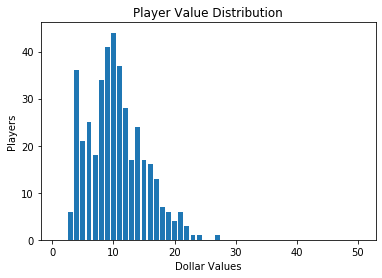

In [16]:
# Before we smooth things out, let's visualize the distribution of our player values.

# Convert our dollar values into a numpy array and then round them to the nearest integer. 
dollar_values_array = np.rint(draft_pool['Dollar_Value'].to_numpy())

# And convert the numpy array to a normal list because I want to use list.count() below.
dollar_values_list = [int(value) for value in dollar_values_array]

# x_values should be the number of times a dollar value appears
x_values = list(range(1,51)) # Manually entering this will make it easier when we chart these again later

# y_values should be the dollar value
y_values = []
for number in x_values:
    if dollar_values_list.count(number) == 0:
        y_values.append(0)
    else:
        y_values.append(dollar_values_list.count(number))

# Plot the distribution
plt.bar(x_values, y_values)

plt.xlabel('Dollar Values')
plt.ylabel('Players')
plt.title("Player Value Distribution")

plt.show()

Looking at this distribution, does it match how you think of your draft? Probably not. For one thing, there are no \\$1 players (in my league, usually 40-60 get drafted at that price) and there are no players above \\$25. In my league, the top guys go for \\$50 or more, plus inflation, which we'll factor in at the end.

Here are the steps: 

1. Take the lowest valued player's `Dollar_value` and subtract an amount that would make the `Dollar_value` exactly equeal to \\$1. For example, if the lowest-ranked player's `Dollar_value` was \\$3.50, you would subtract \\$2.50 to get to \\$1.
2. Subtract that same amount (\\$2.50 in our example) from every player's `Dollar_value`.
3. Find the sum of every player's `Dollar_Value`.
4. Divide the `total_dollar_pool` by the sum from step 3. The result should be some number greater than 1.
5. Multiply every player's value by the result from step 4. 

Basically, we are redistributing value from the bottom of the pool to the top of the pool. 

*NB: there is almost certainly a fancy statistical method for doing this, but I wasn't able to find it.*

In [17]:
# Create a new column for our smoothed values
draft_pool['True_Dollar_Value'] = draft_pool['Dollar_Value']

# Define how many $1 players you want in your pool 
one_dollar_players = 75

i = -1

while abs(i) <= one_dollar_players: 
    lowest_player_dollar_value = draft_pool.iloc[i,-1]   

    # run the loop until the lowest value gets to 1.0     
    while lowest_player_dollar_value > 1.0:
        # 1. Subtract an amount that would make the `Dollar_value` exactly equeal to \\$1. 
        amount_to_subtract = lowest_player_dollar_value - 1
        
        # 2. Subtract that same amount from every player's `Dollar_value`.
        subtract_it = lambda x: x - amount_to_subtract if x > 1 else x # 2.21410
        draft_pool['True_Dollar_Value'] = draft_pool.True_Dollar_Value.apply(subtract_it)
          
        # 3. Find the sum of every player's `Dollar_Value`.
        adjusted_dollar_value_after_subtraction = draft_pool.True_Dollar_Value.sum() 

        # 4. Divide the `total_dollar_pool` by the sum from step 3. The result should be some number greater than 1.
        dollar_value_multiplier = total_dollar_pool / adjusted_dollar_value_after_subtraction

        # 5. Multiply every player's value by the result from step 4. 
        multiply_it = lambda x: x * dollar_value_multiplier
        draft_pool['True_Dollar_Value'] = draft_pool.True_Dollar_Value.apply(multiply_it)

        # Update the lowest_player_dollar_value so the loop condition works
        lowest_player_dollar_value = draft_pool.iloc[i,-1] # 1.27
    
    # decrease i and move to the next highest row
    i -=1


Let's take a look at what we have now:

In [18]:
print(draft_pool.head(60))
print(draft_pool.tail(50))

# Uncomment to save a new CSV.
# draft_pool.to_csv('Exports/my_draft_pool_smoothed.csv')


      Class                Name   PA    R  HR  RBI  SB    OBP   IP    QS SV  \
0    Hitter          Mike Trout  675  124  44  112  14  0.439    x     x  x   
1    Hitter    Christian Yelich  672  112  36  100  22    0.4    x     x  x   
2    Hitter    Ronald Acuna Jr.  680  107  37   94  29  0.363    x     x  x   
3    Hitter      Cody Bellinger  640  100  42  116  12  0.386    x     x  x   
4    Hitter    Francisco Lindor  692  112  36   95  22  0.355    x     x  x   
5    Hitter         Trea Turner  683  103  22   75  39  0.354    x     x  x   
6    Hitter        Bryce Harper  664  102  41  102  11  0.383    x     x  x   
7   Pitcher         Gerrit Cole    x    x   x    x   x      x  202  22.5  0   
8    Hitter           Juan Soto  646   97  34  106   9  0.407    x     x  x   
9    Hitter        Jose Ramirez  648   96  31  101  23  0.362    x     x  x   
10  Pitcher        Max Scherzer    x    x   x    x   x      x  202  22.5  0   
11   Hitter        Mookie Betts  688  112  32   87  

## Further smoothing

Things look pretty good! We have about 50 players valued at \\$1 (a few more if we round down, but whatever). And everyone else's values have increased.

But something is still off. If you're following along with my data, Mike Trout is only at \\$36, which feels too low to me. Once I add in inflation of around 20\%, that will go up to \\$43. But last year in my league he was drafted for \\$70! Now, I didn't value him that high, but someone did and I'm worried that if I run with these numbers, I'm going to end up with none of the top-25 hitters because everyone is paying more.

So I'm going to reallocate some of the money at the top and move it away from the middle. This follows my general stars & scrubs strategy. If you prefer a more balanced approach, then you might want to skip this step (and decrease the number of \\$1 players).


In [20]:
# Note: you may have to run this a few times and then restart the kernel and redo it a few times to get things right.
# Until I find a more magical way to do this, it's going to involve some trial and error.
# For this example, I'm going to run it once with a lower_bound of 15 and then again with a lower_bound of 25. This
# will push more money into the top of the distribution.

upper_bound = 100 # players with True_Dollar_Value BELOW this number will be adjusted
lower_bound = 15  # players with True_Dollar_Value ABOVE this number will be adjusted

adjustment_rate = 1.4 # the multiplier to apply to the players in the range

adjust_top_players = lambda x: x * adjustment_rate if x < upper_bound and x > lower_bound else x
draft_pool['True_Dollar_Value'] = draft_pool.True_Dollar_Value.apply(adjust_top_players)

adjusted_dollar_value_after_subtraction = draft_pool.True_Dollar_Value.sum()

dollar_value_multiplier = total_dollar_pool / adjusted_dollar_value_after_subtraction

multiply_it = lambda x: x * dollar_value_multiplier if x > 1 else x
draft_pool['True_Dollar_Value'] = draft_pool.True_Dollar_Value.apply(multiply_it)


In [21]:
print(draft_pool.head(50))
print(draft_pool.tail())
print(draft_pool.True_Dollar_Value.sum())

      Class                Name   PA    R  HR  RBI  SB    OBP   IP    QS SV  \
0    Hitter          Mike Trout  675  124  44  112  14  0.439    x     x  x   
1    Hitter    Christian Yelich  672  112  36  100  22    0.4    x     x  x   
2    Hitter    Ronald Acuna Jr.  680  107  37   94  29  0.363    x     x  x   
3    Hitter      Cody Bellinger  640  100  42  116  12  0.386    x     x  x   
4    Hitter    Francisco Lindor  692  112  36   95  22  0.355    x     x  x   
5    Hitter         Trea Turner  683  103  22   75  39  0.354    x     x  x   
6    Hitter        Bryce Harper  664  102  41  102  11  0.383    x     x  x   
7   Pitcher         Gerrit Cole    x    x   x    x   x      x  202  22.5  0   
8    Hitter           Juan Soto  646   97  34  106   9  0.407    x     x  x   
9    Hitter        Jose Ramirez  648   96  31  101  23  0.362    x     x  x   
10  Pitcher        Max Scherzer    x    x   x    x   x      x  202  22.5  0   
11   Hitter        Mookie Betts  688  112  32   87  

Looks much better! Now let's see how it looks when graphed out.

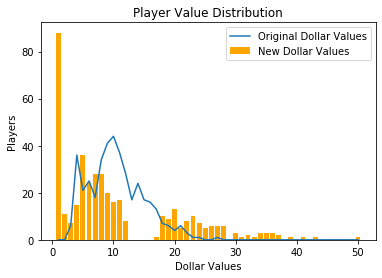

In [22]:
# First, let's convert our dollar values into a numpy array and then round them to the nearest integer. 
dollar_values_array = np.rint(draft_pool['Dollar_Value'].to_numpy())
true_dollar_values_array = np.rint(draft_pool['True_Dollar_Value'].to_numpy())

# print(dollar_values_array)
# print(true_dollar_values_array)

# And convert the numpy array to a normal list because I want to use list.count() below.
dollar_values_list = [int(value) for value in dollar_values_array]
true_dollar_values_list = [int(value) for value in true_dollar_values_array]

# x_values should be the number of times a dollar value appears
x_values = list(range(1,51))

# y_values should be the dollar value
y_values = []
y2_values = []
for number in x_values:
    if dollar_values_list.count(number) == 0:
        y_values.append(0)
    else:
        y_values.append(dollar_values_list.count(number))
for number in x_values:
    if true_dollar_values_list.count(number) == 0:
        y2_values.append(0)
    else:
        y2_values.append(true_dollar_values_list.count(number))

# Plot the distribution
plt.plot(x_values, y_values, label="Original Dollar Values")
plt.bar(x_values, y2_values, color="orange",label="New Dollar Values")

plt.xlabel('Dollar Values')
plt.ylabel('Players')
plt.title("Player Value Distribution")
plt.legend()

plt.show()


So, this method isn't perfect. It's looking better, although there are some weird gaps in there. I'm feeling OK with it for now but I might come back and tinker with it to smooth things out a bit.

You'll have to play with it a bit to get numbers that work for you, or email me and tell me of a better way to handle this.


In [24]:
# Uncomment to export your data as a CSV and you're ready to draft...
#draft_pool.to_csv('Exports/my_draft_pool_smoothed_adjusted.csv')

# Calculating Inflation

A lot of auction leagues are also keeper leagues. The players held out of the draft have a huge impact on the auction prices and if you've ever drafted in a keeper league without accounting for inflation, you may have had a wicked surprise -- the market values are way different from what the 'true' values are for a given player. 

Sure, paying \\$70 for Mike Trout might seem outrageous, but the money all has to get spent and leaving the draft with unspent money is a mistake that could haunt you. Better to 'overpay' and build a better roster than refuse to overpay and leave with money that you can't take with you.

### Preparing inflation data

Before we can begin, we need to leave the notebook and do some work in Excel so we know which players were kept. Since my league hasn't set its keepers yet, I'm going to create a fake version on my own.


In [26]:
from shutil import copyfile
# Uncomment this and run it to create your file. Be careful not to run it again or you might overwrite your data!
#copyfile("Exports/my_draft_pool_smoothed_adjusted.csv", "League_Data/blank_keeper_data.csv")

Now that you have your file, open it up in Excel. Before doing anything else, save the file under a new name, so you don't accidentally overwrite it.

Next, you're going to manually add your league's keepers in the spreadsheet. Create two new columns, one called 'Salary' and one called 'Keeper' (you can look at my_keeper_data.csv to see how I filled it out).

In the `Keeper` column, add `True` if the player was kept, then add their salary in the `Salary` column.


In [28]:
# Import the keeper list CSV as a dataframe
my_league_keeper_list = pd.read_csv('League_Data/my_keeper_data.csv',thousands=',')
my_league_keeper_list.drop(labels="Unnamed: 20",axis=1,inplace=True)
print(my_league_keeper_list.head())

   Unnamed: 0   Class              Name   PA    R  HR  RBI  SB    OBP IP QS  \
0         0.0  Hitter        Mike Trout  675  124  44  112  14  0.439  x  x   
1         1.0  Hitter  Christian Yelich  672  112  36  100  22    0.4  x  x   
2         2.0  Hitter  Ronald Acuna Jr.  680  107  37   94  29  0.363  x  x   
3         3.0  Hitter    Cody Bellinger  640  100  42  116  12  0.386  x  x   
4         4.0  Hitter  Francisco Lindor  692  112  36   95  22  0.355  x  x   

  SV SO ERA WHIP  Total_SGPs  Dollar_Value  True_Dollar_Value Keeper  Salary  
0  x  x   x    x   19.705009     27.445497          50.270246   True    75.0  
1  x  x   x    x   17.535716     24.424067          43.347398   True    35.0  
2  x  x   x    x   16.667379     23.214631          40.576279   True    11.0  
3  x  x   x    x   16.060512     22.369375          38.639587   True    12.0  
4  x  x   x    x   15.515233     21.609901          36.899444    NaN     NaN  


The dataframe should now have columns for `Keeper` and `Salary`. Now we can calculate inflation.

In [29]:
# Create a dataframe to get the keeper salary/value aggregates
keeper_data = my_league_keeper_list.groupby(['Class','Keeper']).sum()

# Hitters
hitter_kept_value = keeper_data.loc['Hitter','True_Dollar_Value']
hitter_kept_salary = keeper_data.loc['Hitter','Salary']

hitter_remaining_dollars = hitter_dollar_allocation - hitter_kept_salary
hitter_remaining_value = hitter_dollar_allocation - hitter_kept_value

# If you don't have past league data, you can manually assign a multiplier (e.g. 1.25) to hitter_inflation_rate
hitter_inflation_rate = hitter_remaining_dollars / hitter_remaining_value

# Pitchers
pitcher_kept_value = keeper_data.loc['Pitcher','True_Dollar_Value']
pitcher_kept_salary = keeper_data.loc['Pitcher','Salary']

pitcher_remaining_dollars = pitcher_dollar_allocation - pitcher_kept_salary
pitcher_remaining_value = pitcher_dollar_allocation - pitcher_kept_value

# If you don't have past league data, you can manually assign a multiplier (e.g. 1.25) to pitcher_inflation_rate
pitcher_inflation_rate = pitcher_remaining_dollars / pitcher_remaining_value

# Let's apply the inflation rates
apply_inflation = lambda row: row['True_Dollar_Value'] * hitter_inflation_rate \
    if row['Class'] == 'Hitter' \
    else row['True_Dollar_Value'] * pitcher_inflation_rate

my_league_keeper_list['Inflated_Value'] = my_league_keeper_list.apply(apply_inflation,axis=1)

# Export a new spreadsheet
my_league_keeper_list.to_csv('Exports/my_draft_pool_smoothed_adjusted_inflated.csv')

print(my_league_keeper_list.head(3))
print(my_league_keeper_list.tail(3))

   Unnamed: 0   Class              Name   PA    R  HR  RBI  SB    OBP IP  ...  \
0         0.0  Hitter        Mike Trout  675  124  44  112  14  0.439  x  ...   
1         1.0  Hitter  Christian Yelich  672  112  36  100  22    0.4  x  ...   
2         2.0  Hitter  Ronald Acuna Jr.  680  107  37   94  29  0.363  x  ...   

  SV SO ERA WHIP Total_SGPs  Dollar_Value  True_Dollar_Value  Keeper Salary  \
0  x  x   x    x  19.705009     27.445497          50.270246    True   75.0   
1  x  x   x    x  17.535716     24.424067          43.347398    True   35.0   
2  x  x   x    x  16.667379     23.214631          40.576279    True   11.0   

   Inflated_Value  
0       72.707093  
1       62.694409  
2       58.686471  

[3 rows x 21 columns]
     Unnamed: 0 Class Name   PA    R   HR  RBI   SB  OBP   IP  ...   SV   SO  \
442         NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
443         NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
444         NaN

In [33]:
print(hitter_inflation_rate)
print(pitcher_inflation_rate)

Keeper
True    1.446325
dtype: float64
Keeper
True    0.928357
dtype: float64


## Finishing up

There should now be a column called `Inflated_Value` with inflated value numbers in "my_draft_pool_smoothed_adjusted_inflated.csv". 

Before we call it a day, let's drop a couple unnecessary columns.

In [30]:
# First, let's get rid of the Keepers, they're not going to be in our final draft pool.
for row in my_league_keeper_list.itertuples():
    if row.Keeper == True:
        my_league_keeper_list.drop([row.Index],inplace=True)

my_league_keeper_list.drop(['Keeper','Salary','Total_SGPs','Dollar_Value'], inplace=True,axis=1)
print(my_league_keeper_list.head())


    Unnamed: 0    Class              Name   PA    R  HR  RBI  SB    OBP   IP  \
4          4.0   Hitter  Francisco Lindor  692  112  36   95  22  0.355    x   
5          5.0   Hitter       Trea Turner  683  103  22   75  39  0.354    x   
6          6.0   Hitter      Bryce Harper  664  102  41  102  11  0.383    x   
10        10.0  Pitcher      Max Scherzer    x    x   x    x   x      x  202   
11        11.0   Hitter      Mookie Betts  688  112  32   87  17  0.371    x   

      QS SV   SO   ERA  WHIP  True_Dollar_Value  Inflated_Value  
4      x  x    x     x     x          36.899444       53.368573  
5      x  x    x     x     x          36.834924       53.275257  
6      x  x    x     x     x          36.328449       52.542730  
10  22.5  0  268  3.27  1.04          35.169951       32.650270  
11     x  x    x     x     x          34.670387       50.144634  


In [31]:
# Finally, we can export our clean data into a new file
my_league_keeper_list.to_csv('Exports/my_draft_pool_smoothed_adjusted_inflated_clean.csv')

And, we're done! Going through it the first time may take a while, but once you understand how to use it, you should be saving many hours every year. And there are a lot of ways you can further customize the notebook. 

Here are some ideas:

* Creating composite projections with multiple projection systems.
* Adjusting the value distribution based on different strategies.
* Handling for position scarcity and rules to make sure that enough players of every position are in the draft pool (e.g. catchers).

Good luck.